# Setup & Libraries

In [2]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision.datasets import Flowers102
from torch.utils.data import DataLoader
from torchvision.models import efficientnet_b0
from tqdm import tqdm
import torchvision.models as models
import matplotlib.pyplot as plt
from torchvision import datasets
import numpy as np
import os
import random
import math
from tqdm import tqdm

def set_seed(seed = 0):
    random.seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

set_seed(888)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cuda


In [3]:
!pip install timm -q
!git clone https://github.com/TooTouch/VPT.git

Cloning into 'VPT'...
remote: Enumerating objects: 59, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 59 (delta 15), reused 48 (delta 11), pack-reused 0 (from 0)
Receiving objects: 100% (59/59), 511.07 KiB | 6.55 MiB/s, done.
Resolving deltas: 100% (15/15), done.


In [4]:
import sys, os
sys.path.append("VPT")
from models import VPT

# Data Loading

In [3]:
# resize images to 224x224 in line with ResNet input size, normalize images so mean and std are in line with pretrained statistics
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [4]:
# load the dataset
train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
val_dataset = datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
test_dataset = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)

100%|██████████| 345M/345M [00:17<00:00, 19.8MB/s]
100%|██████████| 502/502 [00:00<00:00, 2.00MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 42.1MB/s]


In [5]:
# create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

# Utility Functions

In [19]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0.0, verbose=True, model_path='model.pt'):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf
        self.verbose = verbose
        self.model_path = model_path

    def early_stop(self, validation_loss, model):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0

        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1

            if self.counter >= self.patience:
                if self.verbose:
                    print("Early stopping triggered.")
                return True
        return False

In [20]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Train", leave=False):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total


@torch.no_grad()
def eval_one_epoch(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Val", leave=False):
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, preds = outputs.max(1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    return running_loss / total, correct / total



In [25]:
def test_loop(model, loader, criterion, device):
    model.eval()
    correct = 0
    running_loss = 0.0
    total = 0

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * images.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    test_loss = running_loss / total
    test_acc = correct / total

    return test_acc, test_loss

# Vision Prompt Tuning:
We will be focusing on 2 variants:
1. Shallow VPT
2. Deep VPT

For this experiment, we adopted the VPT implementation provided in an open source repository on GitHub (https://github.com/TooTouch/VPT), which was based on the original paper’s implementation of VPT.

# Vision Prompt Tuning (Shallow)

Inserts prompt tokens only at input layer of transformer

In [23]:
NUM_CLASS = 102
PROMPT_TOKENS = 5
PROMPT_DROPOUT = 0.0
PROMPT_TYPE = 'shallow'
LR = 1e-3
WEIGHT_DECAY = 1e-4
NUM_EPOCH = 20
PATIENCE = 3

history_shallow = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

model_shallow = VPT(modelname='vit_base_patch16_224',num_classes=NUM_CLASS,pretrained=True,
                    prompt_tokens=PROMPT_TOKENS, prompt_dropout=PROMPT_DROPOUT ,prompt_type=PROMPT_TYPE).to(DEVICE)

optimizer_shallow = torch.optim.AdamW(filter(lambda p: p.requires_grad, model_shallow.parameters()),lr=1e-3,weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
early_stopper = EarlyStopper(patience=PATIENCE, min_delta=0.0, verbose=True, model_path="best_vpt_shallow.pth")

best_val_loss = np.inf

for epoch in range(NUM_EPOCH):
    print(f"\n[Shallow] Epoch {epoch+1}/{NUM_EPOCH}")

    train_loss, train_acc = train_one_epoch(model_shallow, train_loader, optimizer_shallow, criterion, DEVICE)

    val_loss, val_acc = eval_one_epoch(model_shallow, val_loader, criterion, DEVICE)

    history_shallow["train_loss"].append(train_loss)
    history_shallow["train_acc"].append(train_acc)
    history_shallow["val_loss"].append(val_loss)
    history_shallow["val_acc"].append(val_acc)

    print(f"  Train loss: {train_loss:.4f} | acc: {train_acc:.4f}")
    print(f"  Val   loss: {val_loss:.4f} | acc: {val_acc:.4f}")

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model_shallow.state_dict(), "best_vpt_shallow.pth")
        print("  (Saved best shallow model)")

    if early_stopper.early_stop(val_loss, model_shallow):
        print(f"  Early stopping triggered at epoch {epoch+1}")
        break


82278 trainable params

[Shallow] Epoch 1/20


  Train loss: 2.9626 | acc: 0.4784
  Val   loss: 0.7628 | acc: 0.9039
  (Saved best shallow model)

[Shallow] Epoch 2/20


  Train loss: 0.2543 | acc: 0.9833
  Val   loss: 0.2571 | acc: 0.9637
  (Saved best shallow model)

[Shallow] Epoch 3/20


  Train loss: 0.0565 | acc: 1.0000
  Val   loss: 0.1906 | acc: 0.9735
  (Saved best shallow model)

[Shallow] Epoch 4/20


  Train loss: 0.0310 | acc: 1.0000
  Val   loss: 0.1711 | acc: 0.9745
  (Saved best shallow model)

[Shallow] Epoch 5/20


  Train loss: 0.0214 | acc: 1.0000
  Val   loss: 0.1540 | acc: 0.9735
  (Saved best shallow model)

[Shallow] Epoch 6/20


  Train loss: 0.0153 | acc: 1.0000
  Val   loss: 0.1447 | acc: 0.9765
  (Saved best shallow model)

[Shallow] Epoch 7/20


  Train loss: 0.0120 | acc: 1.0000
  Val   loss: 0.1377 | acc: 0.9755
  (Saved best shallow model)

[Shallow] Epoch 8/20


  Train loss: 0.0096 | acc: 1.0000
  Val   loss: 0.1328 | acc: 0.9775
  (Saved best shallow model)

[Shallow] Epoch 9/20


  Train loss: 0.0081 | acc: 1.0000
  Val   loss: 0.1286 | acc: 0.9804
  (Saved best shallow model)

[Shallow] Epoch 10/20


  Train loss: 0.0070 | acc: 1.0000
  Val   loss: 0.1240 | acc: 0.9794
  (Saved best shallow model)

[Shallow] Epoch 11/20


  Train loss: 0.0061 | acc: 1.0000
  Val   loss: 0.1220 | acc: 0.9804
  (Saved best shallow model)

[Shallow] Epoch 12/20


  Train loss: 0.0053 | acc: 1.0000
  Val   loss: 0.1194 | acc: 0.9804
  (Saved best shallow model)

[Shallow] Epoch 13/20


  Train loss: 0.0047 | acc: 1.0000
  Val   loss: 0.1173 | acc: 0.9794
  (Saved best shallow model)

[Shallow] Epoch 14/20


  Train loss: 0.0042 | acc: 1.0000
  Val   loss: 0.1146 | acc: 0.9814
  (Saved best shallow model)

[Shallow] Epoch 15/20


  Train loss: 0.0038 | acc: 1.0000
  Val   loss: 0.1126 | acc: 0.9814
  (Saved best shallow model)

[Shallow] Epoch 16/20


  Train loss: 0.0035 | acc: 1.0000
  Val   loss: 0.1110 | acc: 0.9814
  (Saved best shallow model)

[Shallow] Epoch 17/20


  Train loss: 0.0032 | acc: 1.0000
  Val   loss: 0.1098 | acc: 0.9814
  (Saved best shallow model)

[Shallow] Epoch 18/20


  Train loss: 0.0029 | acc: 1.0000
  Val   loss: 0.1091 | acc: 0.9804
  (Saved best shallow model)

[Shallow] Epoch 19/20


  Train loss: 0.0027 | acc: 1.0000
  Val   loss: 0.1067 | acc: 0.9814
  (Saved best shallow model)

[Shallow] Epoch 20/20


  Train loss: 0.0025 | acc: 1.0000
  Val   loss: 0.1068 | acc: 0.9804


In [26]:
test_acc, test_loss = test_loop(model_shallow, test_loader, criterion, DEVICE)
print(f"Test Acc: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

Test Acc: 0.9798, Test Loss: 0.1114


# Vision Prompt Tuning (Deep)


Inserts prompts at every transformer block

In [27]:
PROMPT_TYPE_DEEP = 'deep'

history_deep = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

model_deep = VPT(
    modelname='vit_base_patch16_224',
    num_classes=NUM_CLASS,
    pretrained=True,
    prompt_tokens=PROMPT_TOKENS,
    prompt_dropout=PROMPT_DROPOUT,
    prompt_type=PROMPT_TYPE_DEEP
).to(DEVICE)

optimizer_deep = torch.optim.AdamW(
    filter(lambda p: p.requires_grad, model_deep.parameters()),
    lr=LR,
    weight_decay=WEIGHT_DECAY
)

early_stopper_deep = EarlyStopper(
    patience=PATIENCE,
    min_delta=0.0,
    verbose=True,
    model_path="best_vpt_deep.pth"
)

best_val_loss_deep = np.inf

for epoch in range(NUM_EPOCH):
    print(f"\n[Deep] Epoch {epoch+1}/{NUM_EPOCH}")

    train_loss, train_acc = train_one_epoch(
        model_deep, train_loader, optimizer_deep, criterion, DEVICE
    )

    val_loss, val_acc = eval_one_epoch(
        model_deep, val_loader, criterion, DEVICE
    )

    history_deep["train_loss"].append(train_loss)
    history_deep["train_acc"].append(train_acc)
    history_deep["val_loss"].append(val_loss)
    history_deep["val_acc"].append(val_acc)

    print(f"  Train loss: {train_loss:.4f} | acc: {train_acc:.4f}")
    print(f"  Val   loss: {val_loss:.4f} | acc: {val_acc:.4f}")

    if val_loss < best_val_loss_deep:
        best_val_loss_deep = val_loss
        torch.save(model_deep.state_dict(), "best_vpt_deep.pth")
        print("  (Saved best deep model)")

    if early_stopper_deep.early_stop(val_loss, model_deep):
        print(f"  Early stopping triggered at epoch {epoch+1}")
        break


[Deep] Epoch 1/20


  Train loss: 3.3192 | acc: 0.3951
  Val   loss: 0.8508 | acc: 0.8794
  (Saved best deep model)

[Deep] Epoch 2/20


  Train loss: 0.1784 | acc: 0.9784
  Val   loss: 0.1523 | acc: 0.9696
  (Saved best deep model)

[Deep] Epoch 3/20


  Train loss: 0.0120 | acc: 0.9980
  Val   loss: 0.1314 | acc: 0.9725
  (Saved best deep model)

[Deep] Epoch 4/20


  Train loss: 0.0043 | acc: 1.0000
  Val   loss: 0.1163 | acc: 0.9745
  (Saved best deep model)

[Deep] Epoch 5/20


  Train loss: 0.0023 | acc: 1.0000
  Val   loss: 0.1132 | acc: 0.9735
  (Saved best deep model)

[Deep] Epoch 6/20


  Train loss: 0.0017 | acc: 1.0000
  Val   loss: 0.1104 | acc: 0.9755
  (Saved best deep model)

[Deep] Epoch 7/20


  Train loss: 0.0013 | acc: 1.0000
  Val   loss: 0.1083 | acc: 0.9735
  (Saved best deep model)

[Deep] Epoch 8/20


  Train loss: 0.0011 | acc: 1.0000
  Val   loss: 0.1067 | acc: 0.9735
  (Saved best deep model)

[Deep] Epoch 9/20


  Train loss: 0.0010 | acc: 1.0000
  Val   loss: 0.1052 | acc: 0.9755
  (Saved best deep model)

[Deep] Epoch 10/20


  Train loss: 0.0008 | acc: 1.0000
  Val   loss: 0.1041 | acc: 0.9755
  (Saved best deep model)

[Deep] Epoch 11/20


  Train loss: 0.0007 | acc: 1.0000
  Val   loss: 0.1030 | acc: 0.9755
  (Saved best deep model)

[Deep] Epoch 12/20


  Train loss: 0.0007 | acc: 1.0000
  Val   loss: 0.1018 | acc: 0.9755
  (Saved best deep model)

[Deep] Epoch 13/20


  Train loss: 0.0006 | acc: 1.0000
  Val   loss: 0.1006 | acc: 0.9755
  (Saved best deep model)

[Deep] Epoch 14/20


  Train loss: 0.0005 | acc: 1.0000
  Val   loss: 0.0997 | acc: 0.9755
  (Saved best deep model)

[Deep] Epoch 15/20


  Train loss: 0.0005 | acc: 1.0000
  Val   loss: 0.0986 | acc: 0.9755
  (Saved best deep model)

[Deep] Epoch 16/20


  Train loss: 0.0005 | acc: 1.0000
  Val   loss: 0.0977 | acc: 0.9765
  (Saved best deep model)

[Deep] Epoch 17/20


  Train loss: 0.0004 | acc: 1.0000
  Val   loss: 0.0970 | acc: 0.9765
  (Saved best deep model)

[Deep] Epoch 18/20


  Train loss: 0.0004 | acc: 1.0000
  Val   loss: 0.0961 | acc: 0.9784
  (Saved best deep model)

[Deep] Epoch 19/20


  Train loss: 0.0004 | acc: 1.0000
  Val   loss: 0.0955 | acc: 0.9775
  (Saved best deep model)

[Deep] Epoch 20/20


  Train loss: 0.0003 | acc: 1.0000
  Val   loss: 0.0946 | acc: 0.9775
  (Saved best deep model)


In [28]:
test_acc_deep, test_loss_deep = test_loop(
    model_deep, test_loader, criterion, DEVICE
)
print(f"[Deep] Test Acc: {test_acc_deep:.4f}, Test Loss: {test_loss_deep:.4f}")

[Deep] Test Acc: 0.9776, Test Loss: 0.0988


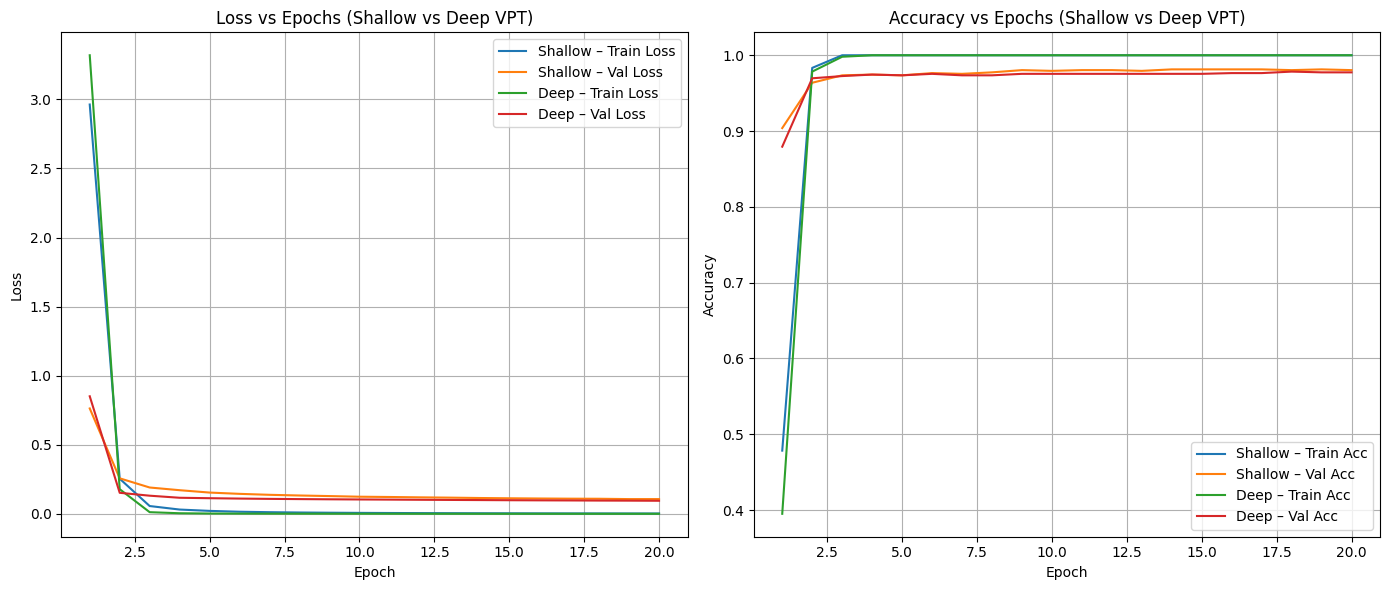

In [31]:
epochs_sh = range(1, len(history_shallow["train_loss"]) + 1)
epochs_dp = range(1, len(history_deep["train_loss"]) + 1)

plt.figure(figsize=(14, 6))

# ---------------- LOSS ----------------
plt.subplot(1, 2, 1)
plt.plot(epochs_sh, history_shallow["train_loss"], label="Shallow – Train Loss")
plt.plot(epochs_sh, history_shallow["val_loss"],   label="Shallow – Val Loss")
plt.plot(epochs_dp, history_deep["train_loss"],    label="Deep – Train Loss")
plt.plot(epochs_dp, history_deep["val_loss"],      label="Deep – Val Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epochs (Shallow vs Deep VPT)")
plt.grid(True)
plt.legend()

# ---------------- ACC ----------------
plt.subplot(1, 2, 2)
plt.plot(epochs_sh, history_shallow["train_acc"], label="Shallow – Train Acc")
plt.plot(epochs_sh, history_shallow["val_acc"],   label="Shallow – Val Acc")
plt.plot(epochs_dp, history_deep["train_acc"],    label="Deep – Train Acc")
plt.plot(epochs_dp, history_deep["val_acc"],      label="Deep – Val Acc")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Accuracy vs Epochs (Shallow vs Deep VPT)")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()